# Assignment 3 – Topic Modeling and Clustering for Online Social Media Data

*Due: Friday January 10 at 17:00 CET*

In the third assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use topic modeling and clustering to identify topics in online social media data. The objectives of this assignment are:
- understand and process the text data
- use the clustering algorithm to determine clusters in real-life data
- use the Latent Dirichlet Allocation algorithm to identify discussed topics in real-life text data 
- use the visualization tools to validate the results of unsupervised learning and interpret your findings
- reflect on the difference between two type of unsupervised learning algorithms

In this assignment, you are going to discover the different ‘topics’ from a real social media text dataset. The project is divided into two parts (4 subtasks):

- The first part contains data processing (1.1) and feature extraction (1.2) from the raw text data.
- In the second part, you will implement two methods (2.1), a topic modeling method and a clustering method, to identify topics from the processed data. Then, the evaluation will be done by using visualization tools (2.2). 

Provided files:
- The dataset: data/raw_data.txt
- A tutorial notebook showcases some packages you could use for this assignment (optional): Ass3_tutorial.ipynb
- Some sample visualization codes for interpreting the topic results: viz_example.ipynb

In [1]:
# TODO: import the packages
import io
import spacy
import preprocessor as p
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
import warnings
import pyLDAvis
import pyLDAvis.lda_model


 ## Dataset:
 The data used in this assignment is Dutch text data. We collected the COVID-19 crisis related messages from online social media (Twitter) from January to November 2021. Then, a subset of raw tweets was randomly sampled. In total, our dataset includes the text data of about 100K messages. **To protect the data privacy, please only use this dataset within the course.**

In [2]:
# read the data

def phase0_open_txt_stream(filename):
    return io.open(filename, "r", encoding="utf-8")

pipe = phase0_open_txt_stream("data/raw_data.txt")

for i in range(5):
    print(next(pipe))
    print("")

pipe.close()


Hahah, het verzet is begonnen. Het knalt hier op z'n best hoor. Voor mijn dieren vind ik het erg, maar f@ck die maffe regering hier. Gelukkig nieuwjaar!


RT @D66Vught: Het is 2021! https://t.co/LpPuFPuqR8


@MijumewAndCo Happy new year mij!


Fantastisch dat ik zoveel vuurwerk hoor..... We worden echt wakker yes. En het boeit mij niet wat een ander er van denkt.\nOp naar een Great Awakening en happy new year 😃🎉🙏❤️


Gelukkig nieuwjaar allemaal!!!! Binnen exact een maand ben ik jarig en ik hoop dat ik dan eindelijk birthdaySEX kan hebben xxx




 ## 0. Before you start the Project: 
 The provided messages in the raw dataset were collected based on 10 different themes that relate to the COVID-19 crisis. Here is a list of all themes:
 -	Lockdown
 -	Face mask
 -	Social distancing
 -	Loneliness
 -	Happiness
 -	Vaccine
 -	Testing
 -  Curfew
 -  Covid entry pass
 -  Work from home

Before starting your project, you need to first filter the messages (all messages are in Dutch) and use the messages belonging to only one theme for the topic identification. 
 
If you have submitted the theme preference, you can skip the following paragraph.

*Please notice that there will be maximum two teams working on a same theme. In this way, we hope that each group will develop their own dataset and come up with interesting results.*

 ## 1.1 Data Processing
 In the first part of the assignment, please first filter the messages and use the messages belonging to your allocated theme for the identification of topics. For that you will need to:
 -	Design your query (e.g. a regular expression or a set of keywords) and filter the related messages for your allocated theme. 
 -	Clean your filtered messages and preprocess them into the right representation. Please refer to the text data pre-processing and representation methods discussed in the lecture. You may use some of the recommended packages for text data preprocessing and representation.

In [3]:
# Load Spacy model with nl_score_news_sm
nlp = spacy.load("nl_core_news_sm")
# Add extra stop words to spacy stop word list
nlp.Defaults.stop_words.add("rt")

# TODO: filter the related messages
# Keywords for the face mask theme
kws = [
    'vaccinatie', 'vaccin', 'prik', 'booster', 'inenting', 
    'coronavaccin', 'vaccineren', 'vaccinatiebewijs', 'vaccinatiegraad', 
    'vaccinatieplicht', 'vaccinatiecampagne', 'vaccine', 'jab', 'shot', 'boost', 'jab', 'pfizer'
    'boostershot', 'vaccinepass', 'vaccination', 'coronavaccine', 'vaccinationrate'
]
tweets = []
data_file = 'data/raw_data.txt'

with open(data_file, "r", encoding="utf-8") as fin:
    for line in fin:
        line = line.replace('\\n', ' ')
        line = ' '.join(line.lower().strip().split())
        for kw in kws:
            if kw in line:
                tweets.append(line)
                break

print(f"Filtered {len(tweets)} tweets for the theme: Vaccine")
for tweet in tweets[:10]:
    print(tweet)

# TODO: clean and preprocess the messages
# Clean tweets by removing URLs, emojis, reserved words, mentions, smileys, numbers
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.RESERVED, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)

tweets = [p.clean(tweet) for tweet in tweets]
print("\nCleaned tweets:")
for tweet in tweets[:10]:
    print(tweet)

# TODO: represent the messages into formats that can be used in clustering or LDA algorithms (you may need different represention for two algorithms)
processed_tweets = []
for tweet in tqdm.tqdm(tweets, desc="Processing tweets"):
    tweet = nlp(tweet)
    processed_tweet = []
    for token in tweet:
        # Remove stop words
        if token.is_stop:  
            continue
        # Remove punctuation
        if token.is_punct:  
            continue
        # Lemmatization
        processed_tweet.append(token.lemma_)  
    processed_tweet = ' '.join(processed_tweet)
    processed_tweets.append(processed_tweet)

print("\nProcessed tweets:")
for tweet in processed_tweets[:10]:
    print(tweet)


Filtered 28667 tweets for the theme: Vaccine
@martwit57 @lodewijka vaccinatie wil niet zeggen dat je geen corona kan krijgen
rt @hansjmelissen: dat #vuurwerkverbod komt zeker tegelijk met het vaccin? #utrecht
nederland eindigt 2020 met woningnood, record aantallen daklozen, een ondermijnde rechtsstaat, 1 miljoen mensen in armoede en meer doden dan in enig jaar sinds wwii. en 0,0 corona vaccinaties. de verantwoordelijke premier koerst af op een verkiezingsoverwinning. mooi land.
@hansdeboer18 @dartagnanneke "er is ook het risico van vals-positieve resultaten. hoe meer mensen uit niet-risicogebieden worden getest, hoe hoger het percentage zou zijn.” #coronafascisme #vaccindwang #hugodejonge #spoedwet #totalcontrol https://t.co/hwwtem0cip
gaaf om zo'n #stappenplan eens uitgelegd te krijgen, zeker als je er, net als ik, helemaal geen verstand van hebt. #covid_19 #vaccination
druk op kabinet neemt toe: ’eerder vaccineren zorgpersoneel mogelijk’ https://t.co/6nmgqp6nr4 via @telegraaf #snaptu

Processing tweets: 100%|██████████| 28667/28667 [02:24<00:00, 197.92it/s]


Processed tweets:
vaccinatie zeggen corona krijgen
vuurwerkverbod komen tegelijk vaccin Utrecht
Nederland eindigen woningnood record aantalal daklozen ondermijn rechtsstaat miljoen mens armoede dood enig jaar wwii corona vaccinatie verantwoordelijk premier koerst verkiezingsoverwinning mooi land
risico valspositiev resultaat mens niet-risicogebieden getest hoog percentage coronafascisme vaccindwang Hugodejonge Spoedwet totalcontrol
gaaf zo'n stappenplan uitleggen krijgen helemaal verstand covid_19 vaccination
druk kabinet toenemen vacciner zorgpersoneel via snaptuhetnog
zwaar jaar veerkracht Nederlanders enorm vaccin jaar hoop licht einde tunnel maken ondanks beperking mooi veilig jaarwisseling wensen allemaal goed gezond
waartoe immuunsysteem staat vaccinatie beogen Jan leggen simpel
Frankrijk stijgen kritiek traag vaccin-verdeling zeggen ipv licht scandaliseren brengen meneer mevrouw Journalist vraag kritiek medium amper horen betekenen goed werken
moeilijk kort termijn groot hoevee

 ## 1.2 Exploratory Data Analysis
 After preprocessing the data, create at least 2 figures or tables that help you understand the data.

 While exploring the data, you may also think about questions such as:
 - Can you spot any differences between Twitter data and usual text data?
 - Does your exploration reveal some issues that would make it difficult to interpret the topics?
 - Can you improve the data by adding additional preprocessing steps?

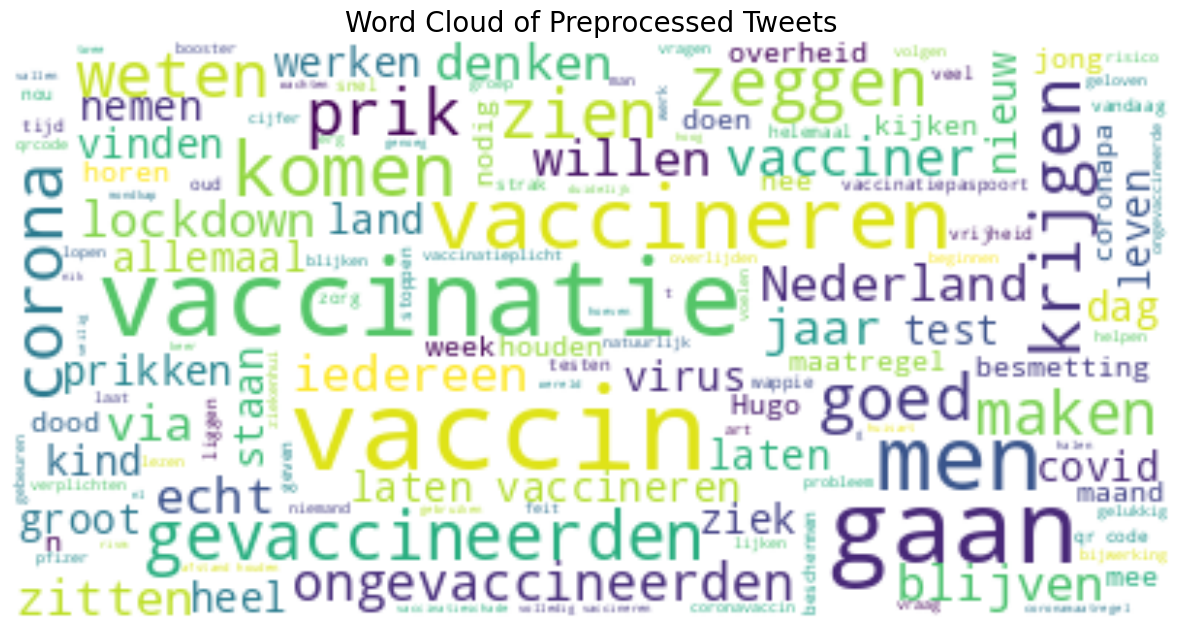

In [4]:
# TODO: plot figure(s)
# Worcloud figure
# Don't forget to pip install wordcloud

warnings.filterwarnings("ignore", category=DeprecationWarning, module="wordcloud")

wordcloud = WordCloud(
    background_color='white',
    max_words=500,
    max_font_size=40,
    random_state=100
).generate(' '.join(processed_tweets))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Preprocessed Tweets", fontsize=20)
plt.show()


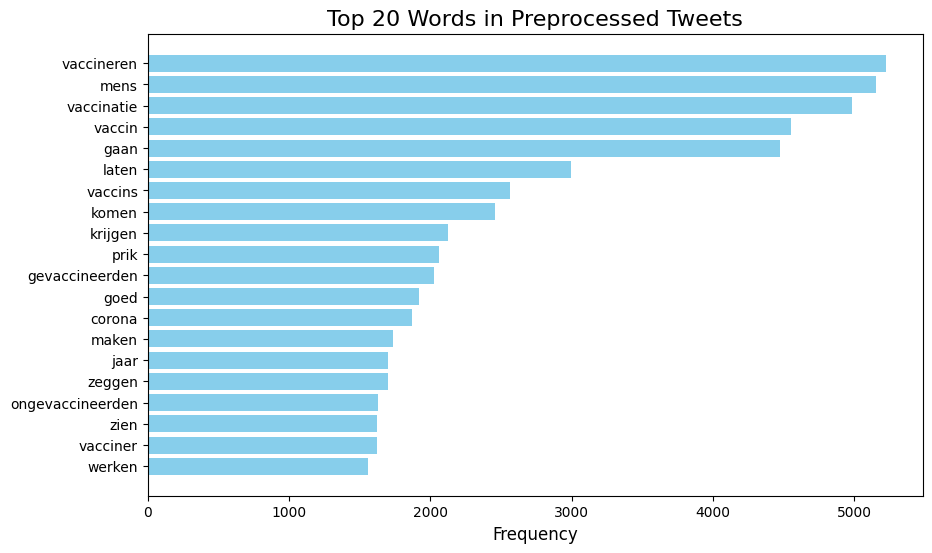

In [5]:
# TODO: plot figure(s)

# Counts word frequencies
word_counts = Counter(" ".join(processed_tweets).split())
most_common_words = word_counts.most_common(20)

# Extracts words and counts
words, counts = zip(*most_common_words)

# Word frequency plot
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.title("Top 20 Words in Preprocessed Tweets", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.show()


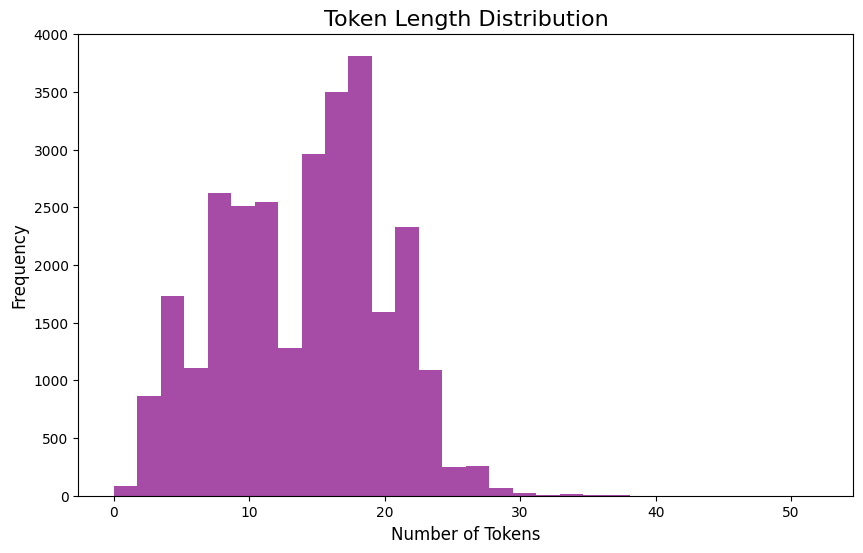

In [6]:
# TODO: plot figure(s)
# Calculates token lengths
token_lengths = [len(tweet.split()) for tweet in processed_tweets]

# Token length plot
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='purple', alpha=0.7)
plt.title("Token Length Distribution", fontsize=16)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


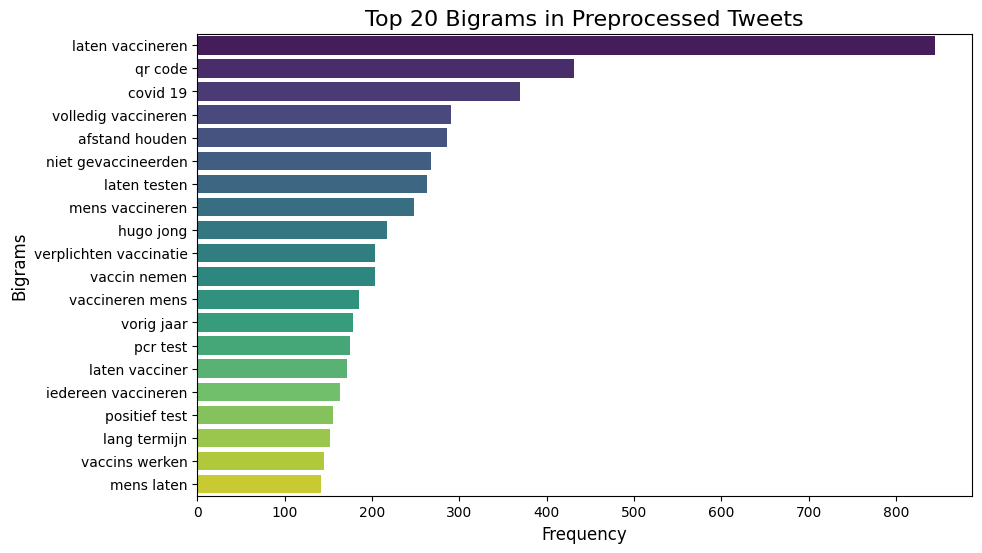

In [7]:
# TODO: plot figure(s)

# Extracts bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(processed_tweets)
bigram_counts = np.asarray(X.sum(axis=0)).flatten()
bigram_features = vectorizer.get_feature_names_out()

# Creates dataframe of bigram frequencies
bigram_data = sorted(zip(bigram_counts, bigram_features), reverse=True)[:20]
counts, bigrams = zip(*bigram_data)

# Bigram plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(bigrams), hue=bigram_data, palette="viridis", legend=False)
plt.title("Top 20 Bigrams in Preprocessed Tweets", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Bigrams", fontsize=12)
plt.show()


## 2.1 Topic modelling and clustering
 In the second part of the assignment, you will first:
 -	Implement a Latent Dirichlet Allocation (LDA) algorithm to identify the discussed topics for your theme
 -	Implement a clustering method  to cluster messages into different groups, then represent the topic of each cluster using a bag of words

While implementing the algorithms, you may use the codes from the recommended packages. In the final report, please explain reasons to select the used algorithm/package. 

In [8]:
# TODO: topic modeling using the LDA algorithm
# Sets parameters and stop word list
dutch_stopwords = list(nlp.Defaults.stop_words)
vectorizer = CountVectorizer(max_features=1000, stop_words=dutch_stopwords)

# Converts to bag of words
bow = vectorizer.fit_transform(processed_tweets)
bow_feature_names = vectorizer.get_feature_names_out()

# Sets LDA parameters
n_topics = 50
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(bow)

# Compute total frequency for each topic
topic_frequencies = lda_model.components_.sum(axis=1)
top_topic_indices = topic_frequencies.argsort()[-5:][::-1]

# Display the 5 topics with the highest total frequency
print("Top 5 LDA Topics with Highest Total Frequency:")
for i in top_topic_indices:
    top_words = [bow_feature_names[j] for j in lda_model.components_[i].argsort()[-10:]]
    total_frequency = topic_frequencies[i]
    print(f"Topic {i + 1}: {', '.join(top_words)} (Total Frequency: {total_frequency:.2f})")


Top 5 LDA Topics with Highest Total Frequency:
Topic 8: hoeven, negatief, gaan, getest, mens, positief, test, testen, vaccineren, laten (Total Frequency: 10564.74)
Topic 3: veilig, corona, virus, bijwerking, mens, experimenteel, krijgen, risico, nemen, vaccin (Total Frequency: 9974.99)
Topic 20: vaccineren, klacht, mondkapje, thuis, werken, mondkap, dragen, blijven, afstand, houden (Total Frequency: 7461.79)
Topic 13: israel, gaan, vaccineren, besmettelijk, spreken, minister, ouder, ongevaccineerden, kind, gevaccineerden (Total Frequency: 7006.01)
Topic 2: termijn, mens, lichaam, komen, vorig, mrna, paar, vaccin, vaccins, jaar (Total Frequency: 6880.54)



Top 5 Clusters with Highest Total Frequency:
Cluster 14: ['vaccinatie', 'mens', 'maken', 'komen', 'verplichten', 'krijgen', 'goed', 'corona', 'overlijden', 'jaar'] (Total Frequency: 4170)
Cluster 32: ['mens', 'vaccineren', 'willen', 'goed', 'vaccinatie', 'maken', 'vaccin', 'komen', 'vacciner', 'ziekenhuis'] (Total Frequency: 3432)
Cluster 15: ['vaccin', 'mens', 'nemen', 'gaan', 'goed', 'werken', 'weten', 'virus', 'maken', 'jaar'] (Total Frequency: 3221)
Cluster 28: ['prik', 'Prik', 'gaan', 'mens', 'e', 'nemen', 'twee', 'halen', 'drie', 'komen'] (Total Frequency: 2831)
Cluster 7: ['gaan', 'vaccinatie', 'mens', 'maken', 'goed', 'gevaccineerden', 'vacciner', 'echt', 'jaar', 'laten'] (Total Frequency: 2763)


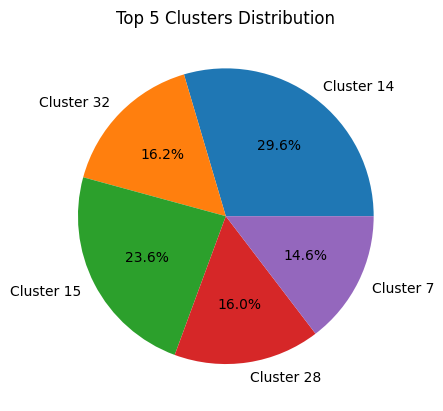

In [9]:
from sklearn.cluster import KMeans

# TODO: cluster the messages using a clustering algorithm
# K-Means Clustering
n_clusters = 50
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(bow)

# Clusters Descriptions
labels = kmeans_model.labels_

# Creates lists
cluster_descriptions = []
cluster_frequencies = []  
cluster_sizes = []  

print("\nTop 5 Clusters with Highest Total Frequency:")
for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_words = Counter(word for idx in cluster_indices for word in processed_tweets[idx].split()).most_common(10)
    cluster_descriptions.append(cluster_words)
    
    # Calculate total frequency for the cluster
    total_frequency = sum(count for word, count in cluster_words)
    cluster_frequencies.append(total_frequency)
    
    # Calculate the size of the cluster
    cluster_size = len(cluster_indices)
    cluster_sizes.append(cluster_size)

# Get indices of the top 5 clusters with highest total frequency
top_cluster_indices = np.argsort(cluster_frequencies)[-5:][::-1]

# Displays the top 5 clusters with highest total frequency
for cluster_id in top_cluster_indices:
    cluster_words = cluster_descriptions[cluster_id]
    total_frequency = cluster_frequencies[cluster_id]
    print(f"Cluster {cluster_id}: {[word for word, count in cluster_words]} (Total Frequency: {total_frequency})")

# Visualize the distribution of the top 5 clusters
top_cluster_sizes = [cluster_sizes[i] for i in top_cluster_indices]
top_cluster_labels = [f"Cluster {i}" for i in top_cluster_indices]

plt.pie(top_cluster_sizes, labels=top_cluster_labels, autopct="%1.1f%%")
plt.title("Top 5 Clusters Distribution")
plt.show()


 ## 2.2 Results, evaluation and Interpretation 
 
Finally, you will describe, evaluate and interpret your findings from two methods. 

- In the report, you need to describe and discuss the similarity and difference of results from two methods.
- While evaluating the results, human judgment is very important, so visualization techniques are helpful to evaluate the identified topics in an interpreted manner. 
    
1. For evaluating the topic modelling algorithm, please first use the interactive tool **[pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=)** to examine the inter-topic separation of your findings. 

2. For interpreting the identified topics / clusters of both algorithms, we provide example code for several visualization techiques. You can use multiple ones to evaluate your results or come up with visualisations on your own. The files contain examples for how to use the visualisation functions.


In [10]:
# TODO: evaluation 

warnings.filterwarnings("ignore", category=DeprecationWarning, module="torchvision")
warnings.filterwarnings('ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=UserWarning)

pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_model, bow, vectorizer, n_jobs=1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7     -0.190055 -0.032883       1        1  3.903147
2      0.084114 -0.200031       2        1  3.723001
19    -0.021075  0.096990       3        1  2.838122
12    -0.074228  0.018779       4        1  2.623108
1      0.142213 -0.175390       5        1  2.595275
46     0.123448 -0.127357       6        1  2.573457
40    -0.014056 -0.065508       7        1  2.536114
3      0.004601 -0.020092       8        1  2.522084
30    -0.035522  0.116112       9        1  2.419754
18     0.070879  0.156677      10        1  2.362563
9     -0.013359 -0.089439      11        1  2.277468
33     0.055401  0.126862      12        1  2.174587
32     0.236603  0.002916      13        1  2.127434
13    -0.136314 -0.006225      14        1  2.090450
43    -0.000814  0.021424      15        1  2.046672
0     -0.167721 -0.070230      16        1  2.036287
16    -0.004762 -0.053723      17        1  2.031109
37    -0.044287  0.027929      18        1  1.967602
41     0.018272  0.040934      19        1  1.961198
20    -0.126087  0.083804      20        1  1.950792
14    -0.034493  0.068441      21        1  1.948661
21     0.115929 -0.052631      22        1  1.941227
38    -0.149655 -0.060537      23        1  1.933994
24     0.024905 -0.051806      24        1  1.898231
15     0.071558  0.147022      25        1  1.897890
29    -0.082850 -0.047559      26        1  1.865222
5     -0.117947 -0.092137      27        1  1.834466
6      0.060872  0.043966      28        1  1.830851
42    -0.032495  0.035131      29        1  1.810031
22    -0.087000  0.010774      30        1  1.789843
17    -0.005026 -0.018221      31        1  1.785590
49     0.039167 -0.086191      32        1  1.781152
48     0.051288  0.208160      33        1  1.764080
44     0.074518  0.130758      34        1  1.740571
8      0.059350 -0.086221      35        1  1.725010
36    -0.080821  0.072254      36        1  1.723312
23     0.065055  0.064223      37        1  1.723247
28     0.033956  0.066134      38        1  1.709223
47    -0.050137 -0.009022      39        1  1.707941
35     0.160042  0.003374      40        1  1.688319
45     0.028610  0.147099      41        1  1.672922
11     0.143328 -0.022987      42        1  1.634677
27    -0.090798 -0.012511      43        1  1.626699
26    -0.009390  0.124075      44        1  1.589294
4     -0.074953 -0.110239      45        1  1.569320
25     0.041926 -0.017264      46        1  1.542112
31    -0.070587 -0.051657      47        1  1.497375
34     0.165278 -0.143382      48        1  1.344125
10    -0.043073 -0.051470      49        1  1.337921
39    -0.113809 -0.059127      50        1  1.326469, topic_info=               Term         Freq        Total Category  logprob  loglift
821          vaccin  4718.000000  4718.000000  Default  30.0000  30.0000
659            prik  2386.000000  2386.000000  Default  29.0000  29.0000
307  gevaccineerden  2251.000000  2251.000000  Default  28.0000  28.0000
458           laten  2891.000000  2891.000000  Default  27.0000  27.0000
321            goed  1866.000000  1866.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
413            jong    38.979812  1065.659416  Topic50  -4.4751   1.0143
444         krijgen    50.835453  2110.108569  Topic50  -4.2096   0.5967
774            test    38.972026  1472.661138  Topic50  -4.4753   0.6907
844      vaccineren    63.735848  5175.530500  Topic50  -3.9834  -0.0743
822      vaccinatie    35.179459  5235.704327  Topic50  -4.5777  -0.6801

[2065 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0        15  0.275770      00
0        21  0.061282      00
0        22  0.428976      00
0        41  0.214488      00
1        14  0.955566      11
...     ...       ...     ...
997      48  0.048481   zwaar
998      12  0.87

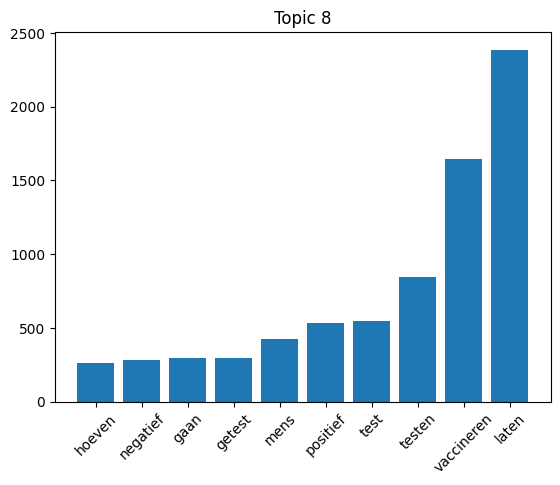

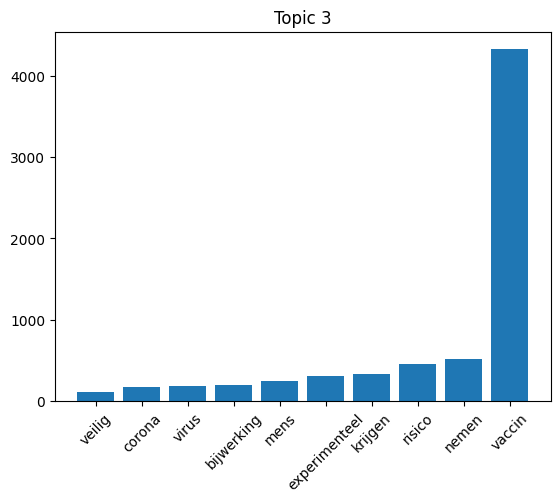

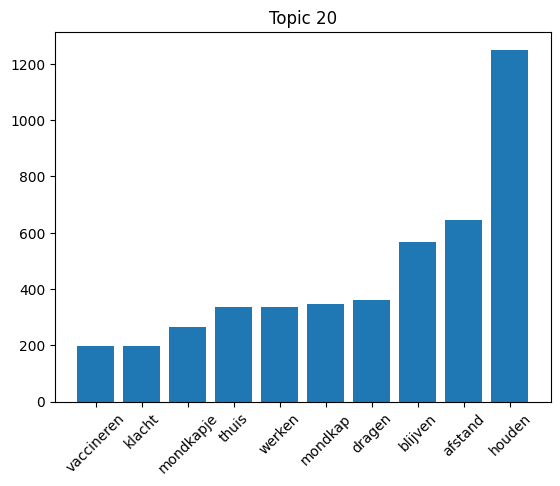

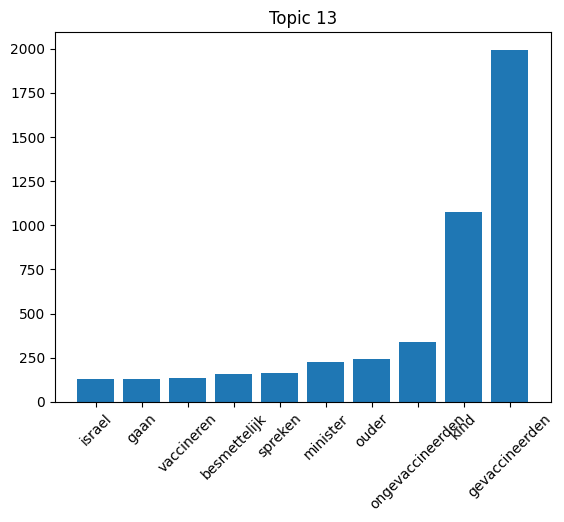

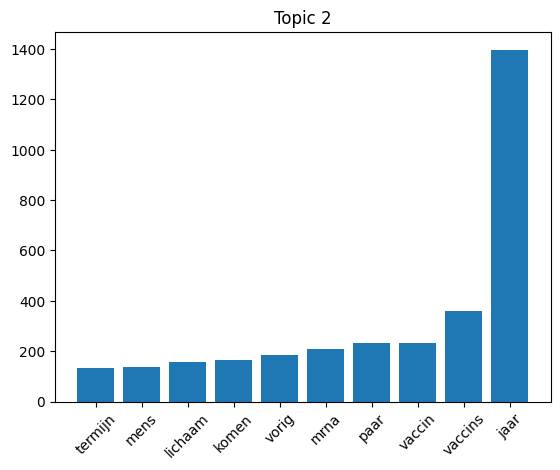

In [11]:
# Bar charts for each topic of the LDA
for i in top_topic_indices:
    topic = lda_model.components_[i]
    top_indices = topic.argsort()[-10:]
    top_words = [bow_feature_names[j] for j in top_indices]
    top_scores = topic[top_indices]
    
    # Create plot
    plt.bar(top_words, top_scores)
    plt.title(f"Topic {i + 1}")
    plt.xticks(rotation=45)
    plt.show()


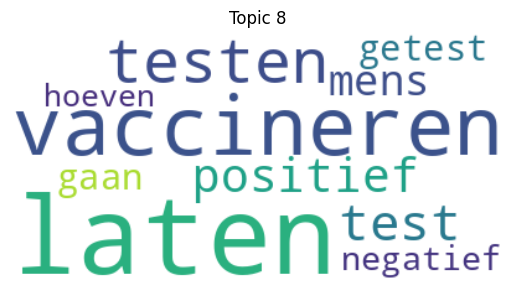

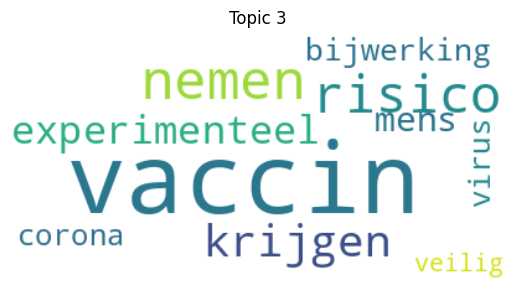

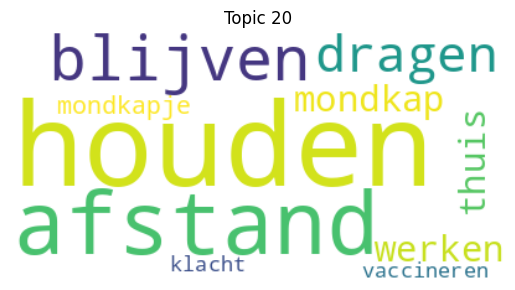

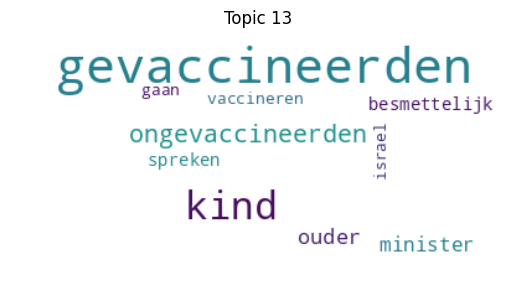

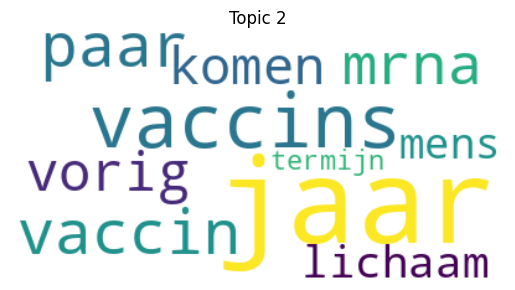

In [13]:
# Word cloud visualization for each cluster of the Kmeans

for i in top_topic_indices:
    topic = lda_model.components_[i]
    top_indices = topic.argsort()[-10:]
    word_freq = {bow_feature_names[j]: topic[j] for j in top_indices}
    
    # Create word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i + 1}")
    plt.show()


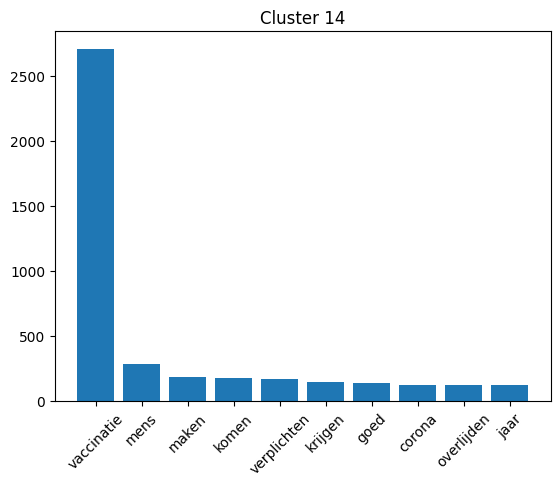

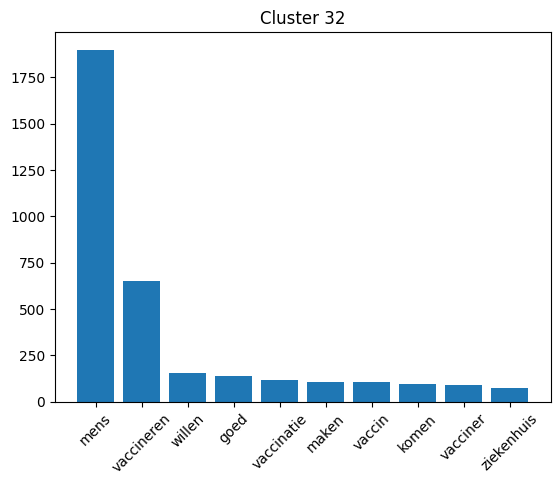

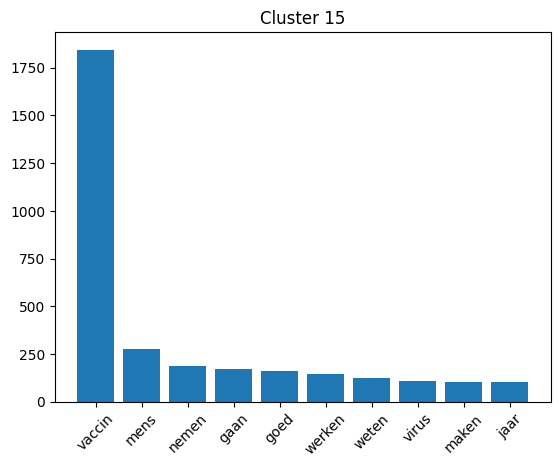

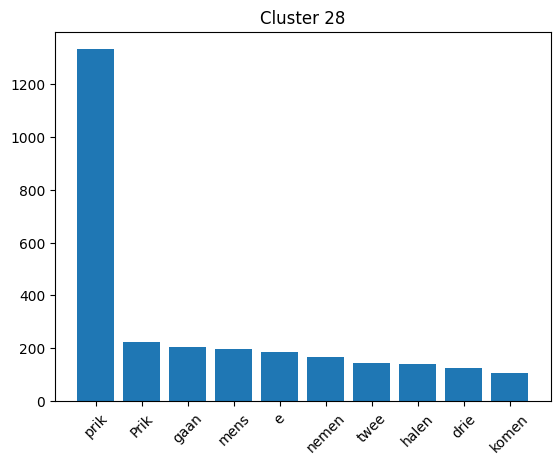

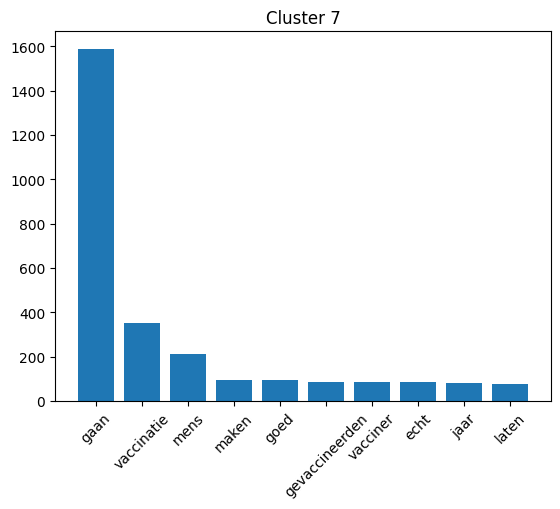

In [14]:
# Bar charts for each cluster of the Kmeans
for cluster_id in top_cluster_indices:
    words = cluster_descriptions[cluster_id]
    word_labels, counts = zip(*words)

    # Create plot
    plt.bar(word_labels, counts)
    plt.title(f"Cluster {cluster_id}")
    plt.xticks(rotation=45)
    plt.show()

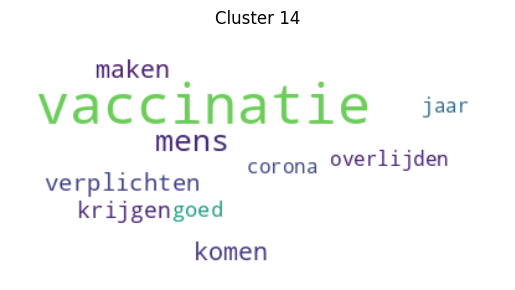

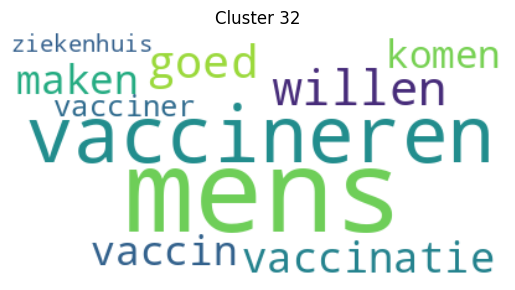

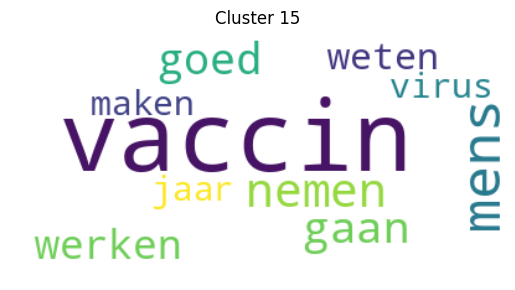

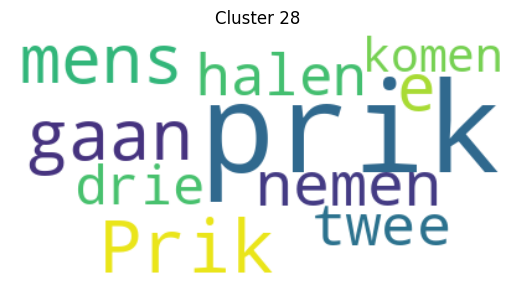

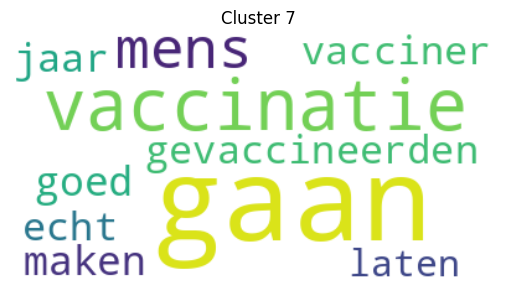

In [15]:
# Word cloud visualization for each cluster of the Kmeans
for cluster_id in top_cluster_indices:
    words = cluster_descriptions[cluster_id]
    word_freq = {word: count for word, count in words}
    
    # Create word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster_id}")
    plt.show()
    

# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Use an LLM-based topic modeling method (for instance, **[BERTopic](https://maartengr.github.io/BERTopic/index.html)** or **[Fastopic](https://github.com/BobXWu/Fastopic)** to identify topics for your theme. Discuss your findings and explain why your chosen method is better (or worse) than LDA.

2. Can you think of other evaluation methods than the provided visualization techniques? If so, implement one and explain why it is a good evaluation for our task.

In [16]:
from fastopic import FASTopic
from topmost.preprocessing import Preprocessing

preprocessing = Preprocessing(vocab_size=10000, stopwords='Dutch')

model = FASTopic(50, preprocessing)
topic_top_words, doc_topic_dist = model.fit_transform(processed_tweets)

parsing texts: 100%|██████████| 28667/28667 [00:00<00:00, 45286.18it/s]
2025-01-09 20:57:59,903 - TopMost - Real vocab size: 10000
2025-01-09 20:58:00,244 - TopMost - Real training size: 28667 	 avg length: 12.603
Training FASTopic: 100%|██████████| 200/200 [05:23<00:00,  1.62s/it]


In [17]:
fig = model.visualize_topic(top_n=5)
fig.show()

In [18]:
fig = model.visualize_topic_hierarchy()
fig.show()

In [19]:
fig = model.visualize_topic_weights(top_n=20, height=500)
fig.show()